In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data/winequality-white.csv", sep=";")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## Prepare X and  y 

In [3]:
data.shape

(4898, 12)

In [4]:
X = data.iloc[:,:-1]
X.shape

(4898, 11)

In [5]:
y = data.iloc[:,-1]
y.shape

(4898,)

## Standardized features

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
X_std = StandardScaler().fit_transform(X)

## Split the dataset

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3918, 11), (980, 11), (3918,), (980,))

## Kernel Ridge Regression

In [11]:
from sklearn.kernel_ridge import KernelRidge

In [12]:
kreg = KernelRidge( alpha=1.0, kernel='rbf', gamma=0.01)

In [13]:
kreg.fit(X_train, y_train)

KernelRidge(alpha=1.0, gamma=0.01, kernel='rbf')

In [14]:
y_pred = np.round(kreg.predict(X_test), 2)
y_pred = kreg.predict(X_test)
# y_pred = np.ceil(kreg.predict(X_test)).astype(int)

In [15]:
from sklearn import metrics

In [16]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

RMSE: 0.71


### Plot

In [17]:
# Compter, pour chaque paire de valeurs (y, y') 
# où y est un vrai score et y' le score prédit,le nombre de ces paires.
# Ce nombre sera utilisé pour modifier 
# la taille des marqueurs correspondants dans un nuage de points
sizes = {}
for (yt, yp) in zip(list(y_test), list(y_pred)):
    if (yt, yp) in sizes.keys():
        sizes[(yt, yp)] += 1
    else:
        sizes[(yt, yp)] = 1        
keys = sizes.keys()

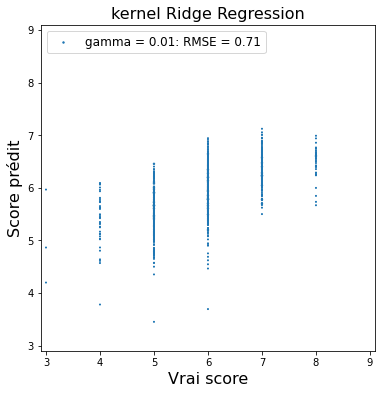

In [18]:
fig = plt.figure(figsize=(6, 6))

plt.scatter([k[0] for k in keys], 
            [k[1] for k in keys], 
             s=[sizes[k] for k in keys], 
            label="gamma = 0.01: RMSE = {:.2f}".format(rmse))

plt.xlabel('Vrai score', fontsize=16)
plt.ylabel(u'Score prédit', fontsize=16)
plt.title('kernel Ridge Regression', fontsize=16)
plt.xlim([2.9, 9.1])
plt.ylim([2.9, 9.1])
plt.legend(loc="upper left", fontsize=12)

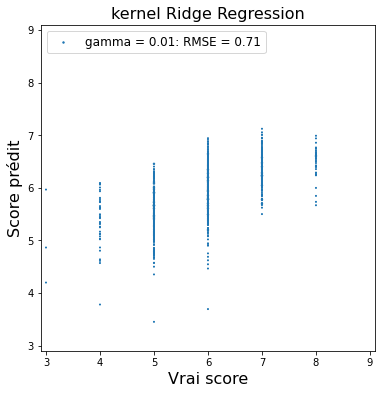

In [19]:
fig = plt.figure(figsize=(6, 6))

plt.scatter([k[0] for k in keys], 
            [k[1] for k in keys], 
             s=[sizes[k] for k in keys], 
            label="INIT gamma = 0.01: RMSE = {:.2f}".format(rmse))

plt.xlabel('Vrai score', fontsize=16)
plt.ylabel(u'Score prédit', fontsize=16)
plt.title('kernel Ridge Regression', fontsize=16)
plt.xlim([2.9, 9.1])
plt.ylim([2.9, 9.1])
plt.legend(loc="upper left", fontsize=12)

## Compare with a larger gamma value
Le paramètre gamma du noyau RBF gaussien joue un rôle important : s'il est trop élevé, la matrice de Gram sur le jeu d'entraînement est dominée par sa diagonale et la kRR ne peut pas apprendre. 

In [20]:
kreg = KernelRidge( alpha=1.0, kernel='rbf', gamma=50)
kreg.fit(X_train, y_train)

#bad_y_pred = kreg.predict(X_test)
bad_y_pred = np.round(kreg.predict(X_test), 2)
#bad_y_pred = np.ceil(kreg.predict(X_test)).astype(int)

bad_rmse = np.sqrt(metrics.mean_squared_error(y_test, bad_y_pred))
print(f"RMSE: {rmse:.2f}")

RMSE: 0.71


In [21]:
bad_sizes = {}
for (yt, yp) in zip(list(y_test), list(bad_y_pred)):
    if (yt, yp) in bad_sizes.keys():
        bad_sizes[(yt, yp)] += 1
    else:
        bad_sizes[(yt, yp)] = 1        
bad_keys = bad_sizes.keys()

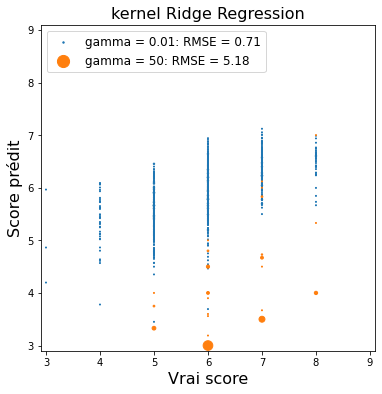

In [23]:
fig = plt.figure(figsize=(6, 6))

plt.scatter([k[0] for k in keys], 
            [k[1] for k in keys], 
             s=[sizes[k] for k in keys], 
            label="INIT gamma = 0.01: RMSE = {:.2f}".format(rmse))



plt.scatter([k[0] for k in bad_keys], 
            [k[1] for k in bad_keys], 
             s=[bad_sizes[k] for k in bad_keys], 
            label="BAD gamma = 50: RMSE = {:.2f}".format(bad_rmse))

plt.xlabel('Vrai score', fontsize=16)
plt.ylabel(u'Score prédit', fontsize=16)
plt.title('kernel Ridge Regression', fontsize=16)
plt.xlim([2.9, 9.1])
plt.ylim([2.9, 9.1])
plt.legend(loc="upper left", fontsize=12)

As we can see on the plot, the values are way off with a large gamme value

## Kernel Ridge Regression with Gridsearch for `C` and `gamma`

In [24]:
from sklearn.model_selection import GridSearchCV

In [37]:
alpha_range = np.logspace(-5, 5, 10)
gamma_range = np.logspace(-2, 1, 4)
params = {
    'alpha':alpha_range,
    'gamma':gamma_range,
}

score = 'neg_mean_squared_error'

In [38]:
grid = GridSearchCV(KernelRidge(kernel='rbf'), scoring=score, param_grid=params, cv=5)

In [39]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KernelRidge(kernel='rbf'),
             param_grid={'alpha': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                         'gamma': array([ 0.01,  0.1 ,  1.  , 10.  ])},
             scoring='neg_mean_squared_error')

In [49]:
grid.best_score_

-0.4981464941305183

In [50]:
grid.best_params_

{'alpha': 0.021544346900318846, 'gamma': 0.01}

In [42]:
cv_y_pred = grid.predict(X_test)

In [47]:
cv_rmse = np.sqrt(metrics.mean_squared_error(y_test, cv_y_pred))
print(f"RMSE: {cv_rmse:.2f}")

RMSE: 0.68


In [43]:
cv_sizes = {}
for (yt, yp) in zip(list(y_test), list(cv_y_pred)):
    if (yt, yp) in cv_sizes.keys():
        cv_sizes[(yt, yp)] += 1
    else:
        cv_sizes[(yt, yp)] = 1        
cv_keys = cv_sizes.keys()

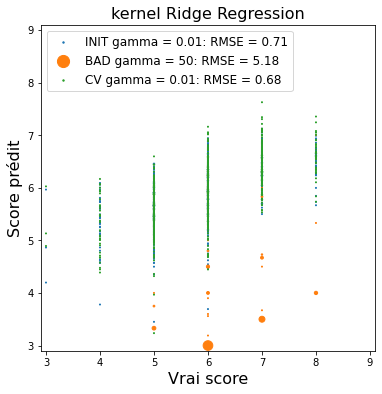

In [53]:
fig = plt.figure(figsize=(6, 6))

plt.scatter([k[0] for k in keys], 
            [k[1] for k in keys], 
             s=[sizes[k] for k in keys], 
            label="INIT gamma = 0.01: RMSE = {:.2f}".format(rmse))

plt.scatter([k[0] for k in bad_keys], 
            [k[1] for k in bad_keys], 
             s=[bad_sizes[k] for k in bad_keys], 
            label="BAD gamma = 50: RMSE = {:.2f}".format(bad_rmse))

plt.scatter([k[0] for k in cv_keys], 
            [k[1] for k in cv_keys], 
             s=[cv_sizes[k] for k in cv_keys], 
            label=f"CV gamma = {grid.best_params_['gamma']}: RMSE = {cv_rmse:.2f}")

plt.xlabel('Vrai score', fontsize=16)
plt.ylabel(u'Score prédit', fontsize=16)
plt.title('kernel Ridge Regression', fontsize=16)
plt.xlim([2.9, 9.1])
plt.ylim([2.9, 9.1])
plt.legend(loc="upper left", fontsize=12)